In [4]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install keras 
from tensorflow.keras import models,layers
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v3 import preprocess_input

In [8]:
import shutil

shutil.unpack_archive("metadata - standardized.csv.zip", "data/")
print("✅ Unzipped successfully!")


✅ Unzipped successfully!


In [5]:
%pwd

'k:\\code\\Glaucoma-Detection-from-Fundus-Image\\research'

In [6]:
    
os.chdir("../")

In [9]:
# data = pd.read_csv('data\metadata - standardized.csv.xlsx', index_col=None)
# import pandas as pd
# conda  install openpyxl
# Load Excel file
# excel_file = "data\metadata - standardized.csv.xlsx"

# Read the first sheet
# data = pd.read_excel("data.csv")

# Save as CSV
data=pd.read_csv("data.csv", index_col=False)

print("✅ Conversion complete! Saved as data.csv")



✅ Conversion complete! Saved as data.csv


In [10]:
def append_ext(fn):
    return fn+".png"

# Select a subset of the dataset where 'fundus' column is not null and not equal to -1
fundus_subset = data[(data['fundus'].notnull()) & (data['fundus'] != -1)]

# Select only the relevant columns for further processing
fundus_subset = fundus_subset[['types', 'fundus', 'names']]

# Create a new column 'combined' by applying the 'append_ext' function to 'names' column
fundus_subset['combined'] = fundus_subset['names'].apply(append_ext)

# Convert 'fundus', 'types' columns to strings for further processing
fundus_subset['fundus'] = fundus_subset['fundus'].astype(str)
fundus_subset['types'] = fundus_subset['types'].astype(str)


In [11]:
# glaucoma fundus images
glaucomaCount = len(fundus_subset[(fundus_subset['types'] == '1')])
print(glaucomaCount)

# healthy fundus images
healthyCount = len(fundus_subset[(fundus_subset['types'] == '0')])
print(healthyCount)

# Randomize the data to create balanced training, validation, and testing sets
fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# Separate the randomized data into a dataframe of healthy and glaucoma subsets
healthy_subset = fundus_subset_random[fundus_subset_random['types'] == '0']
glaucoma_subset = fundus_subset_random[fundus_subset_random['types'] == '1']

testSize = 250
valSize = 250
# get train items
# Shuffle the data
# fundus_subset_random = fundus_subset.sample(frac=1, random_state=1)

# Split indices
healthy_train = healthy_subset.iloc[:healthyCount - valSize - testSize]
healthy_val   = healthy_subset.iloc[healthyCount - valSize - testSize : healthyCount - testSize]
healthy_test  = healthy_subset.iloc[healthyCount - testSize:]

glaucoma_train = glaucoma_subset.iloc[:glaucomaCount - valSize - testSize]
glaucoma_val   = glaucoma_subset.iloc[glaucomaCount - valSize - testSize : glaucomaCount - testSize]
glaucoma_test  = glaucoma_subset.iloc[glaucomaCount - testSize:]

# Combine healthy and glaucoma for final sets
train = pd.concat([healthy_train, glaucoma_train])
val   = pd.concat([healthy_val, glaucoma_val])
test  = pd.concat([healthy_test, glaucoma_test])

print("Train size:", len(train))
print("Validation size:", len(val))
print("Test size:", len(test))


4057
1923
Train size: 4980
Validation size: 500
Test size: 500


In [12]:
print("Train Size: ", len(train))
print("Val Size: ", len(val))
print("Test Size: ", len(test))

Train Size:  4980
Val Size:  500
Test Size:  500


In [13]:
target = 224
batchSize = 8

# Set the class mode to 'binary' for training data generator
classes = 'binary'

# Create the training data generator
trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
trainGen = trainDataGen.flow_from_dataframe(dataframe=train, 
                                            directory='data/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


# Create the validation data generator
valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_dataframe(dataframe=val,
                                           directory='data/full-fundus/full-fundus',   
                                           batch_size = batchSize, 
                                           class_mode = classes,
                                           shuffle=False, 
                                           x_col="combined", 
                                           y_col="types", 
                                           validate_filenames=True, 
                                           target_size=(target, target), 
                                           color_mode='rgb')


# Create the testing data generator
testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_dataframe(dataframe=test,
                                           directory='data/full-fundus/full-fundus',   
                                           batch_size = batchSize, 
                                           class_mode = classes,
                                           shuffle=False, 
                                           x_col="combined", 
                                           y_col="types", 
                                           validate_filenames=True, 
                                           target_size=(target, target), 
                                           color_mode='rgb')

Found 4980 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [15]:
classes = 'sparse'

# Create data generators for healthy and glaucoma subsets for visualization
healthy_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
healthy_subset_Gen = trainDataGen.flow_from_dataframe(dataframe=healthy_subset, 
                                            directory='data/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')


glaucoma_subsetDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
glaucoma_subset_Gen = glaucoma_subsetDataGen.flow_from_dataframe(dataframe=glaucoma_subset, 
                                            directory='data/full-fundus/full-fundus', 
                                            class_mode = classes,
                                            batch_size = batchSize, 
                                            shuffle=True, 
                                            x_col="combined", 
                                            y_col="types", 
                                            validate_filenames=True, 
                                            target_size=(target, target), 
                                            color_mode='rgb')

Found 1923 validated image filenames belonging to 1 classes.
Found 4057 validated image filenames belonging to 1 classes.


In [17]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

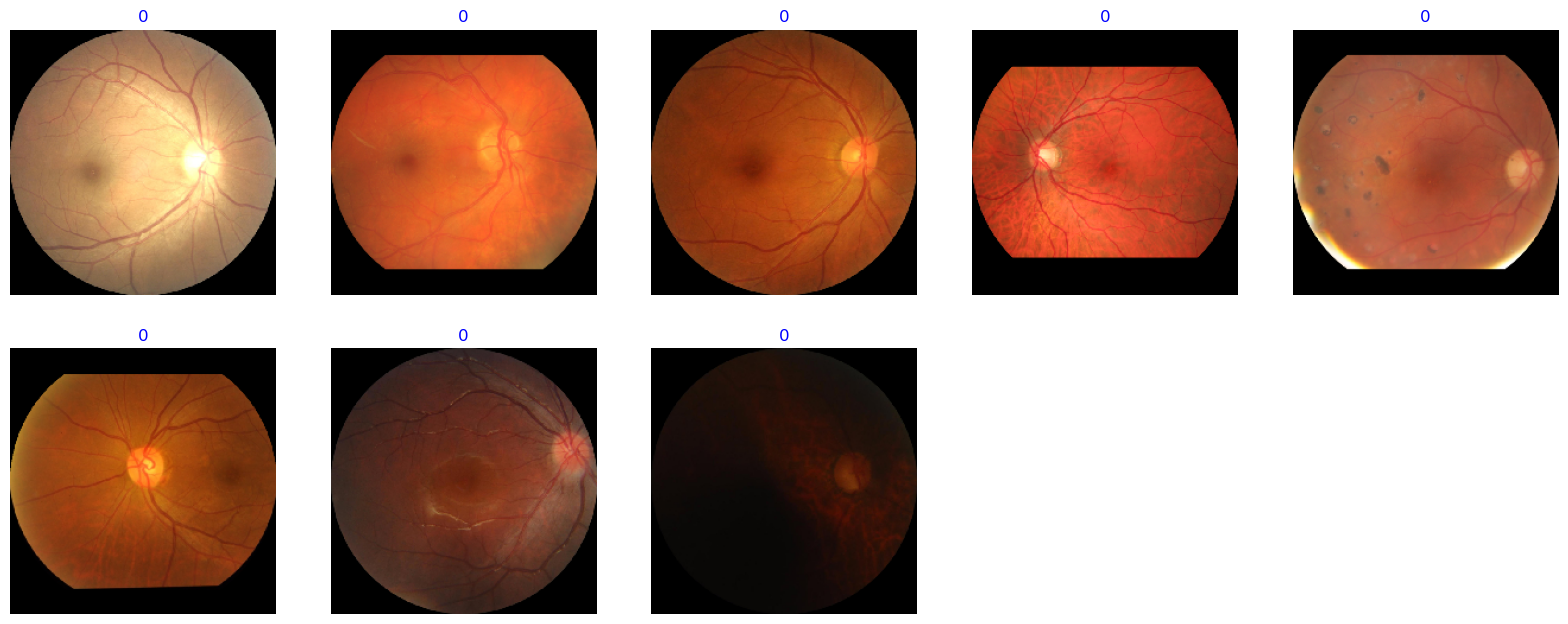

In [18]:
show_images(healthy_subset_Gen)

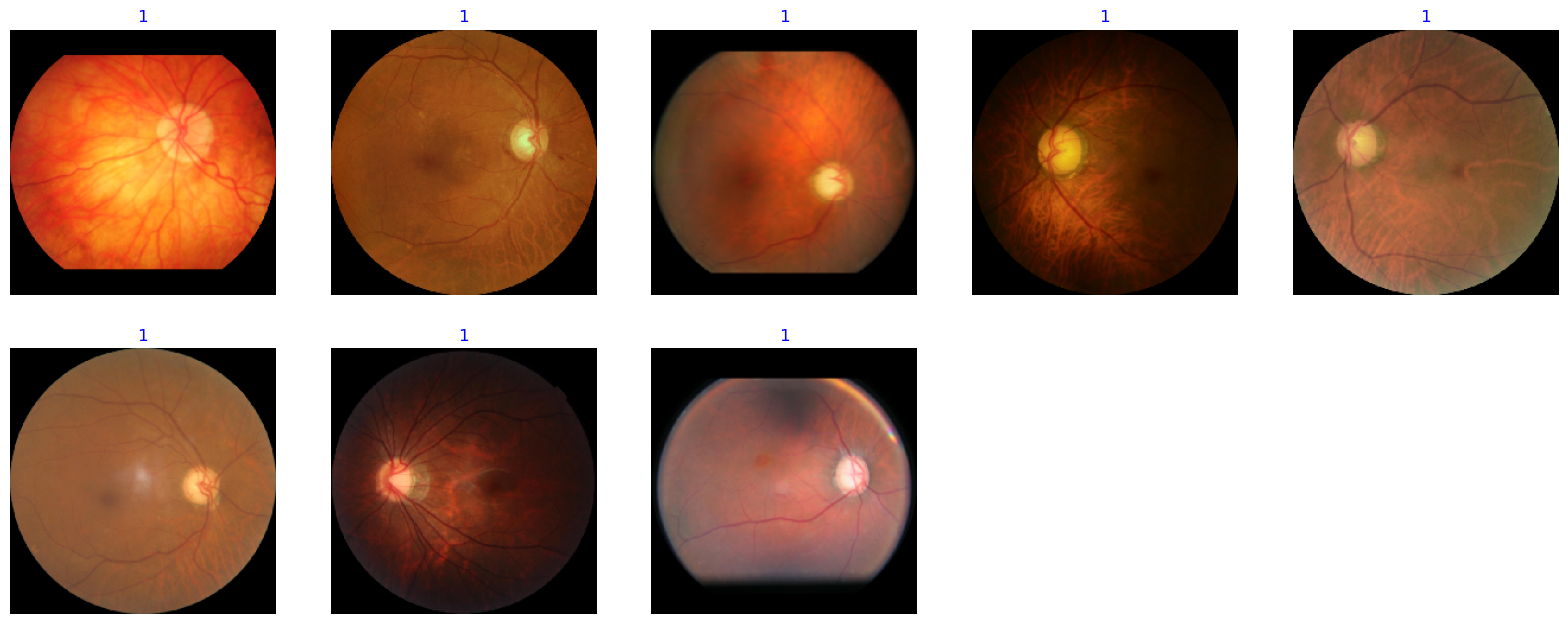

In [19]:
show_images(glaucoma_subset_Gen)

In [43]:
# Load MobileNetV2 as the base model and set layers to be non-trainable
base_for_model = tf.keras.applications.MobileNetV2(weights='imagenet', input_shape=(224,224,3), include_top=False)
for layer in base_for_model.layers:
    layer.trainable = False

9406464/9406464 [==============================] - 3s 0us/step


In [44]:
# Build the custom model on top of the MobileNetV2 base
model = Sequential()
model.add(base_for_model) 
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(GlobalMaxPooling2D()) 
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu')) 
model.add(BatchNormalization()) 
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 7, 7, 512)         655872    
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 512)        2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 7, 7, 512)         262656    
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                        

In [25]:
def f1_score_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)
    return 2 * tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [47]:
# Train the model
history=model.fit(
    trainGen,
    epochs=10,
    batch_size=64,
    validation_data=valGen
)

Epoch 1/10
623/623 [==============================] - 197s 308ms/step - loss: 0.5736 - accuracy: 0.7382 - precision: 0.8029 - recall: 0.8395 - auc: 0.7504 - f1_score_metric: 0.8124 - val_loss: 0.9418 - val_accuracy: 0.6020 - val_precision: 0.5589 - val_recall: 0.9680 - val_auc: 0.7288 - val_f1_score_metric: 0.4979
Epoch 2/10
623/623 [==============================] - 93s 148ms/step - loss: 0.4692 - accuracy: 0.7749 - precision: 0.8231 - recall: 0.8724 - auc: 0.8161 - f1_score_metric: 0.8404 - val_loss: 0.5070 - val_accuracy: 0.7720 - val_precision: 0.8091 - val_recall: 0.7120 - val_auc: 0.8396 - val_f1_score_metric: 0.4184
Epoch 3/10
623/623 [==============================] - 98s 157ms/step - loss: 0.4491 - accuracy: 0.7847 - precision: 0.8336 - recall: 0.8729 - auc: 0.8344 - f1_score_metric: 0.8459 - val_loss: 0.5616 - val_accuracy: 0.7600 - val_precision: 0.7152 - val_recall: 0.8640 - val_auc: 0.8650 - val_f1_score_metric: 0.4694
Epoch 4/10
623/623 [==============================] - 

In [50]:
# Evaluate the model on the validation data
score=model.evaluate(testGen)
score

63/63 [==============================] - 17s 264ms/step - loss: 0.7307 - accuracy: 0.7220 - precision: 0.6773 - recall: 0.8480 - auc: 0.7901 - f1_score_metric: 0.4636


[0.7307009100914001,
 0.722000002861023,
 0.6773163080215454,
 0.8479999899864197,
 0.7900800108909607,
 0.4636140763759613]

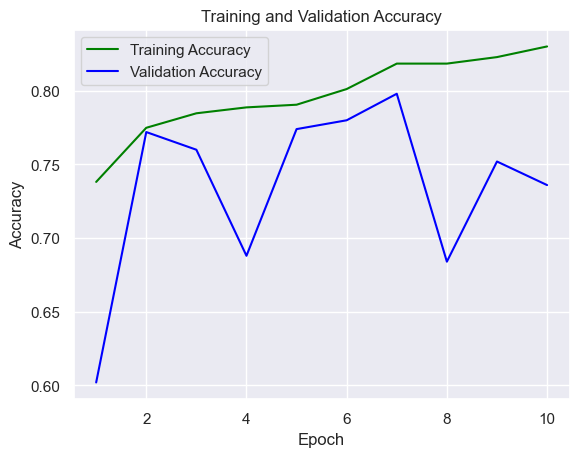

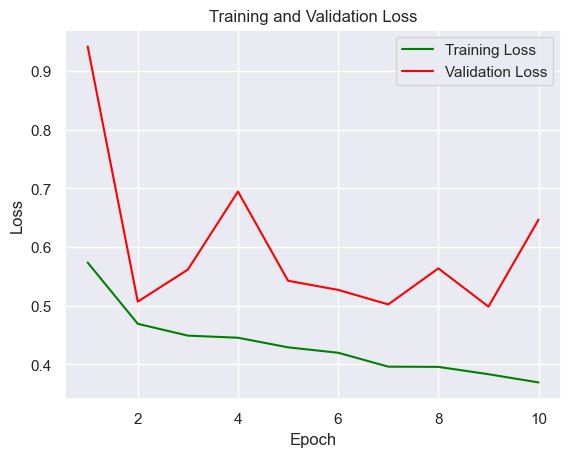

In [49]:
# Plot the training and validation accuracy and loss
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0, Xception

# Example: Using ResNet50 as base
base_model_2 = ResNet50(weights='imagenet', input_shape=(224,224,3), include_top=False)

# Freeze layers
for layer in base_model_2.layers:
    layer.trainable = False


In [23]:
# Build the custom model on top of the MobileNetV2 base
model2= Sequential()
model2.add(base_model_2)               # base CNN (ResNet50, EfficientNetB0, etc.)
model2.add(GlobalMaxPooling2D())     # convert (H, W, C) -> (C,)
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(512, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))  # binary classification
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2

In [26]:
model2.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy','Precision','Recall','AUC',f1_score_metric]
)

In [27]:
print("TensorFlow is built with GPU support:", tf.test.is_built_with_cuda())
print("TensorFlow using GPU:", tf.test.is_gpu_available())  # for TF < 2.10
print("GPUs available:", tf.config.list_physical_devices('GPU'))  # recommended for TF 2.x


TensorFlow is built with GPU support: True
TensorFlow using GPU: True
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import tensorflow as tf
print(tf.__version__)
    

k:\anaconda\envs\py310\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


2.10.1


In [31]:
# Train the model
history=model2.fit(
    trainGen,
    epochs=10,
    batch_size=64,
    validation_data=valGen,)

Epoch 1/10
623/623 [==============================] - 127s 181ms/step - loss: 0.5100 - accuracy: 0.7675 - precision: 0.8351 - recall: 0.8403 - auc: 0.8203 - f1_score_metric: 0.8283 - val_loss: 0.4538 - val_accuracy: 0.8320 - val_precision: 0.8609 - val_recall: 0.7920 - val_auc: 0.8801 - val_f1_score_metric: 0.4447
Epoch 2/10
623/623 [==============================] - 84s 134ms/step - loss: 0.3906 - accuracy: 0.8229 - precision: 0.8718 - recall: 0.8816 - auc: 0.8816 - f1_score_metric: 0.8701 - val_loss: 0.4287 - val_accuracy: 0.8340 - val_precision: 0.8353 - val_recall: 0.8320 - val_auc: 0.8928 - val_f1_score_metric: 0.4582
Epoch 3/10
623/623 [==============================] - 64s 103ms/step - loss: 0.3669 - accuracy: 0.8323 - precision: 0.8781 - recall: 0.8887 - auc: 0.8953 - f1_score_metric: 0.8769 - val_loss: 0.5913 - val_accuracy: 0.6380 - val_precision: 0.5852 - val_recall: 0.9480 - val_auc: 0.8724 - val_f1_score_metric: 0.4928
Epoch 4/10
623/623 [==============================] - 

In [33]:
# Evaluate the model on the validation data
score=model2.evaluate(testGen)
score

63/63 [==============================] - 5s 70ms/step - loss: 0.5488 - accuracy: 0.7740 - precision: 0.7438 - recall: 0.8360 - auc: 0.8727 - f1_score_metric: 0.4611


[0.5488036870956421,
 0.7739999890327454,
 0.7437722682952881,
 0.8360000252723694,
 0.8727279901504517,
 0.46108490228652954]

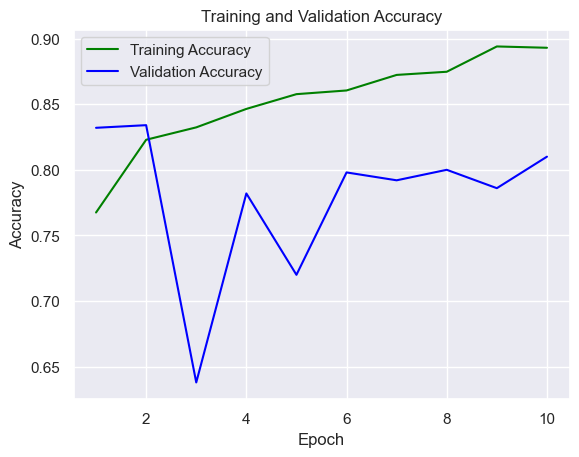

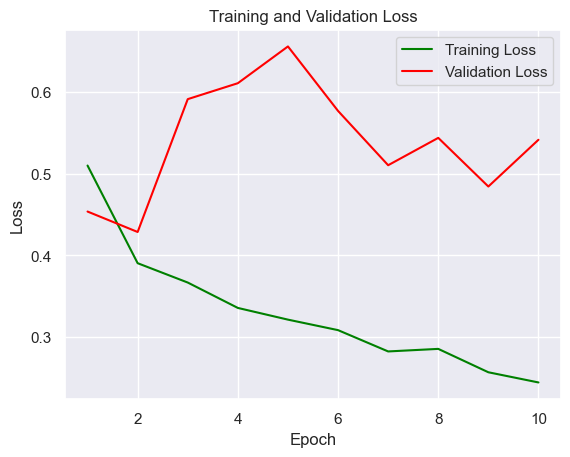

In [34]:
# Plot the training and validation accuracy and loss
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()